In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate,Dropout
from tensorflow.keras.layers import Multiply, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import tarfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nibabel as nib
from nibabel.testing import data_path
from tqdm import tqdm
import segmentation_models as sm
from segmentation_models.metrics import iou_score
focal_loss = sm.losses.cce_dice_loss
from nipype.interfaces.slicer.filtering.n4itkbiasfieldcorrection import N4ITKBiasFieldCorrection
from nipype import Node, Workflow
from nilearn.image import resample_img
from sklearn.model_selection import train_test_split
import random
import SimpleITK as sitk
from nilearn.image import math_img
from nilearn import image as nii
from nilearn import plotting
from nipype.interfaces.ants import N4BiasFieldCorrection
from bias_correction import BiasCorrection
from skimage.exposure import histogram
from skimage import exposure, util

In [3]:
file = tarfile.open(r'D:\capstone_1\skull_stripping\content\NFBS_Dataset.tar.gz')
#find file
file.extractall('/content/')
file.close()

print('Each folder contains..')
print(os.listdir(r'\content\NFBS_Dataset\A00028185'))

Each folder contains..
['sub-A00028185_ses-NFB3_T1w.nii.gz', 'sub-A00028185_ses-NFB3_T1w_brain.nii.gz', 'sub-A00028185_ses-NFB3_T1w_brainmask.nii.gz']


In [4]:
img=nib.load('/content/NFBS_Dataset/A00028185/sub-A00028185_ses-NFB3_T1w.nii.gz')
print('Shape of image=',img.shape)

Shape of image= (256, 256, 192)


In [5]:
brain_mask=[]
brain=[]
raw=[]
for subdir, dirs, files in os.walk('/content/NFBS_Dataset'):
    for file in files:
        #print os.path.join(subdir, file)y
        filepath = subdir + os.sep + file

        if filepath.endswith(".gz"):
          if '_brainmask.' in filepath:
            brain_mask.append(filepath)
          elif '_brain.' in filepath:
            brain.append(filepath)
          else:
            raw.append(filepath)
            
data=pd.DataFrame({'brain_mask':brain_mask,'brain':brain,'raw':raw})
data.head()

,brain_mask,brain,raw
0,/content/NFBS_Dataset\A00028185\sub-A00028185_...,/content/NFBS_Dataset\A00028185\sub-A00028185_...,/content/NFBS_Dataset\A00028185\sub-A00028185_...
1,/content/NFBS_Dataset\A00028352\sub-A00028352_...,/content/NFBS_Dataset\A00028352\sub-A00028352_...,/content/NFBS_Dataset\A00028352\sub-A00028352_...
2,/content/NFBS_Dataset\A00032875\sub-A00032875_...,/content/NFBS_Dataset\A00032875\sub-A00032875_...,/content/NFBS_Dataset\A00032875\sub-A00032875_...
3,/content/NFBS_Dataset\A00033747\sub-A00033747_...,/content/NFBS_Dataset\A00033747\sub-A00033747_...,/content/NFBS_Dataset\A00033747\sub-A00033747_...
4,/content/NFBS_Dataset\A00034854\sub-A00034854_...,/content/NFBS_Dataset\A00034854\sub-A00034854_...,/content/NFBS_Dataset\A00034854\sub-A00034854_...


C:\Users\ksh17\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
C:\Users\ksh17\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys
C:\Users\ksh17\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain ge

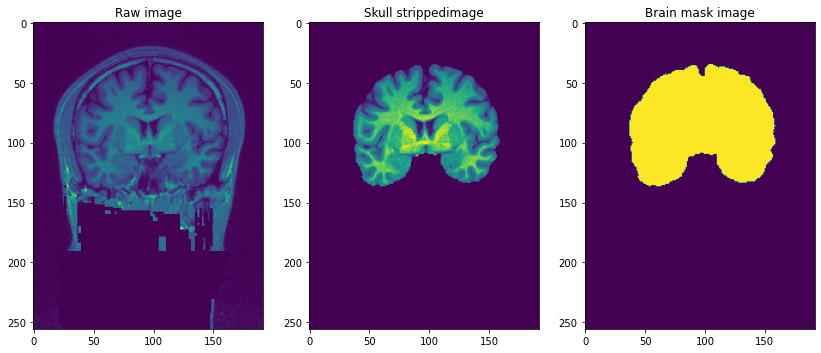

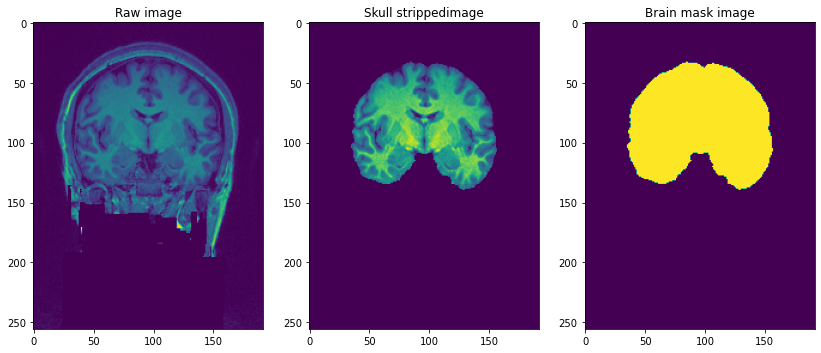

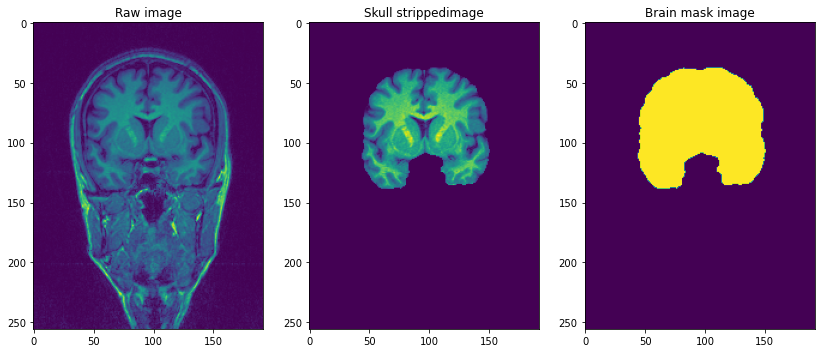

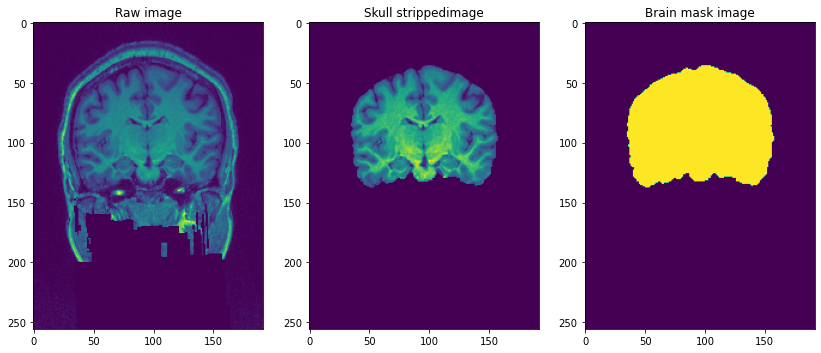

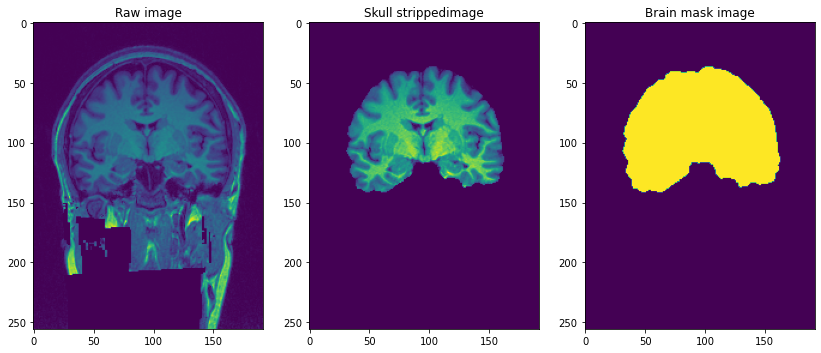

In [6]:
for i in range(5):
    fig,ax=plt.subplots(1,3,figsize=(14,10))
    ax[0].set_title('Raw image')
    img = nib.load(data.raw.iloc[i]).get_data()
    ax[0].imshow(img[img.shape[0]//2])
    ax[1].set_title('Skull strippedimage')
    img = nib.load(data.brain.iloc[i]).get_data()
    ax[1].imshow(img[img.shape[0]//2])
    ax[2].set_title('Brain mask image')
    img = nib.load(data.brain_mask.iloc[i]).get_data()
    ax[2].imshow(img[img.shape[0]//2])

In [ ]:
stik_data=[]
img_raw=[]
img_brain=[]
img_mask=[]

for i in range(125):
    stik_data = sitk.ReadImage(data.raw.iloc[i])
    img_raw.append(nib.load(data.raw.iloc[i]).get_data())
    img_brain.append(nib.load(data.brain.iloc[i]).get_data())
    img_mask.append(nib.load(data.brain_mask.iloc[i]).get_data())

In [32]:
!mkdir resized
target_shape = np.array((96,128,160))
new_resolution = [2,]*3
new_affine = np.zeros((4,4))
new_affine[:3,:3] = np.diag(new_resolution)
new_affine[:3,3] = target_shape*new_resolution/2.*-1
new_affine[3,3] = 1.
raw_index=[]
mask_index=[]

for i in range(len(data)):
    downsampled_and_cropped_nii = resample_img(data.raw.iloc[i], 
                                               target_affine=new_affine, 
                                               target_shape=target_shape, 
                                               interpolation='nearest')
    downsampled_and_cropped_nii.to_filename('resized/raw'+str(i)+'.nii.gz')
    raw_index.append('resized/raw'+str(i)+'.nii.gz')
    downsampled_and_cropped_nii = resample_img(data.brain_mask.iloc[i], 
                                               target_affine=new_affine, 
                                               target_shape=target_shape, 
                                               interpolation='nearest')
    downsampled_and_cropped_nii.to_filename('resized/mask'+str(i)+'.nii.gz')
    mask_index.append('resized/mask'+str(i)+'.nii.gz')

In [ ]:
for i in raw_index:
    image = sitk.ReadImage(i)
    image = sitk.Cast(image, sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    output_corrected = corrector.Execute(image)
    sitk.WriteImage(image,i)

In [ ]:
for i in raw_index:
    image = sitk.ReadImage(i)
    resacleFilter = sitk.RescaleIntensityImageFilter()
    resacleFilter.SetOutputMaximum(255)
    resacleFilter.SetOutputMinimum(0)
    image = resacleFilter.Execute(image)
    sitk.WriteImage(image,i)

In [ ]:
re_raw=[]
re_mask=[]
for i in range(125):
    re_raw.append(nib.load(raw_index[i]).get_data())
    re_mask.append(nib.load(mask_index[i]).get_data())

In [ ]:
class model():
    def __init__(self,):
        pass
    def split(self,resized_img,resized_mask):
        self.X_train,self.X_test,self.y_train,self.y_test=train_test_split(resized_img,resized_mask,test_size=0.1)
        return self.X_train,self.X_test,self.y_train,self.y_test
    def data_gen(self,img_list, mask_list, batch_size):
        c = 0
        n = [i for i in range(len(img_list))]
        random.shuffle(n)
        
        while (True):
            img = np.zeros((batch_size, 96, 128, 160,1)).astype('float')
            mask = np.zeros((batch_size, 96, 128, 160,1)).astype('float')
            
            for i in range(c, c+batch_size):
                train_img = img_list[i]
                train_img=np.expand_dims(train_img,-1)
                
                train_mask = mask_list[i]
                train_mask=np.expand_dims(train_mask,-1)
                
                img[i-c]=train_img
                mask[i-c] = train_mask
                
            c+=batch_size
            if(c+batch_size>=len(img_list)):
                c=0
                random.shuffle(n)
                
            yield img,mask
            
    def convolutional_block(self, data, filters=3, kernel_size=3, batchnorm = True):
        x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size,kernel_size),
                   kernel_initializer = 'he_normal', padding = 'same')(data)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv3D(filters = filters, kernel_size = (kernel_size, kernel_size,kernel_size),
                   kernel_initializer = 'he_normal', padding = 'same')(data)
        if batchnorm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x) 
        return x     

    def resunet_opt(self, input_img, filters = 64, dropout = 0.2, batchnorm = True):
        """Residual Unet + Dense Atrous convolution + Rmp block"""
        conv1 = self.convolutional_block(input_img, filters * 1, kernel_size = 3, batchnorm = batchnorm)
        pool1 = MaxPooling3D((2, 2, 2))(conv1)
        drop1 = Dropout(dropout)(pool1)

        conv2 = self.convolutional_block(drop1, filters * 2, kernel_size = 3, batchnorm = batchnorm)
        pool2 = MaxPooling3D((2, 2, 2))(conv2)
        drop2 = Dropout(dropout)(pool2)

        conv3 = self.convolutional_block(drop2, filters * 4, kernel_size = 3, batchnorm = batchnorm)
        pool3 = MaxPooling3D((2, 2, 2))(conv3)
        drop3 = Dropout(dropout)(pool3)

        conv4 = self.convolutional_block(drop3, filters * 8, kernel_size = 3, batchnorm = batchnorm)
        pool4 = MaxPooling3D((2, 2, 2))(conv4)
        drop4 = Dropout(dropout)(pool4)

        conv5 = self.convolutional_block(drop4, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)
        conv5 = self.convolutional_block(conv5, filters = filters * 16, kernel_size = 3, batchnorm = batchnorm)

        ups6 = Conv3DTranspose(filters * 8, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv5)
        ups6 = concatenate([ups6, conv4])
        ups6 = Dropout(dropout)(ups6)
        conv6 = self.convolutional_block(ups6, filters * 8, kernel_size = 3, batchnorm = batchnorm)

        ups7 = Conv3DTranspose(filters * 4, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv6)
        ups7 = concatenate([ups7, conv3])
        ups7 = Dropout(dropout)(ups7)
        conv7 = self.convolutional_block(ups7, filters * 4, kernel_size = 3, batchnorm = batchnorm)

        ups8 = Conv3DTranspose(filters * 2, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv7)
        ups8 = concatenate([ups8, conv2])
        ups8 = Dropout(dropout)(ups8)
        conv8 = self.convolutional_block(ups8, filters * 2, kernel_size = 3, batchnorm = batchnorm)

        ups9 = Conv3DTranspose(filters * 1, (3, 3, 3), strides = (2, 2, 2), padding = 'same',activation='relu',kernel_initializer='he_normal')(conv8)
        ups9 = concatenate([ups9, conv1])
        ups9 = Dropout(dropout)(ups9)
        conv9 = self.convolutional_block(ups9, filters * 1, kernel_size = 3, batchnorm = batchnorm)

        outputs = Conv3D(1, (1, 1, 2), activation='sigmoid',padding='same')(conv9)
        model = Model(inputs=[input_img], outputs=[outputs])
        return model
    
    def training(self,epochs):
        im_height=96
        im_width=128
        img_depth=160
        epochs=60
        train_gen = self.data_gen(self.X_train,self.y_train, batch_size = 4)
        val_gen = self.data_gen(self.X_test,self.y_test, batch_size = 4)
        channels=1
        input_img = Input((im_height, im_width,img_depth,channels), name='img')
        self.model = self.resunet_opt(input_img, 16, 0.05, True)
        self.model.summary()
        self.model.compile(optimizer=Adam(lr=1e-1),loss=focal_loss,metrics=[iou_score,'accuracy'])
        callbacks=[
            ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, save_weights_only=False)]
        result=self.model.fit(train_gen,steps_per_epoch=16,epochs=epochs,validation_data=val_gen,validation_steps=16,initial_epoch=0,callbacks=callbacks)
        self.model.save("model.h5")

In [ ]:
nn=model()
nn.split(re_raw, re_mask)
nn.training(60)

In [ ]:
def inference(img_path):
    target_shape = np.array((96,128,160))
    new_resolution = [2,]*3
    new_affine = np.zeros((4,4))
    new_affine[:3,:3] = np.diag(new_resolution)
    new_affine[:3,3] = target_shape*new_resolution/2.*-1
    new_affine[3,3] = 1.
    downsampled_and_cropped_nii = resample_img(img_path, 
                                               target_affine=new_affine, 
                                               target_shape=target_shape, 
                                               interpolation='nearest')
    downsampled_and_cropped_nii.to_filename('test_nifti1.nii')
    
    image = sitk.ReadImage('test_nifti1.nii')
    image = sitk.Cast(image, sitk.sitkFloat32)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    output_corrected = corrector.Execute(image)
    sitk.WriteImage(image,'test_nifti1.nii')
    
    image = sitk.ReadImage('test_nifti1.nii')
    rescaleFilter = sitk.RescaleIntensityImageFilter()
    rescaleFilter.SetOutputMaximum(255)
    rescaleFilter.SetOutputMinimum(0)
    image = rescaleFilter.Execute(image)
    sitk.WriteImage(image,'test_nifti1.nii')
    
    orig_img=nib.load('test_nifti1.nii').get_data()
    orig_img=np.expand_dims(orig_img,-1)
    orig_img=np.expand_dims(orig_img,0)
    model=keras.models.load_model('best_model.h5',custom_objects={'categorical_crossentropy_plus_dice_loss':focal_loss,'iou_score':iou_score})
    pred_img=model.predict(orig_img)
    pred_img=np.squeeze(pred_img)
    orig_img=nib.load('test_nifti1.nii').get_data()
    
    func = nib.load('test_nifti1.nii')
    ni_img = nib.Nifti1Image(pred_img, func.affine)
    nib.save(ni_img, 'output_T1w_brain_mask.nii.gz')
    pred_img=nib.load('output_T1w_brain_mask.nii.gz')

    pred_mask = math_img('img > 0.5', img=pred_img)
    crop=pred_mask.get_data()*orig_img
    
    return crop, orig_img

In [ ]:
img_crop, img_ori = inference('test_nifti.nii')

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,10))
ax[0].imshow(img_ori[20])
ax[1].imshow(img_crop[20])